In [ ]:
# LSTM Forex Prediction with Technical Indicators
# Indicators like RSI, SMA, EMA

Epoch 0: Loss = 0.255882
Epoch 10: Loss = 0.112208
Epoch 20: Loss = 0.100770
Epoch 30: Loss = 0.090111
Epoch 40: Loss = 0.091019


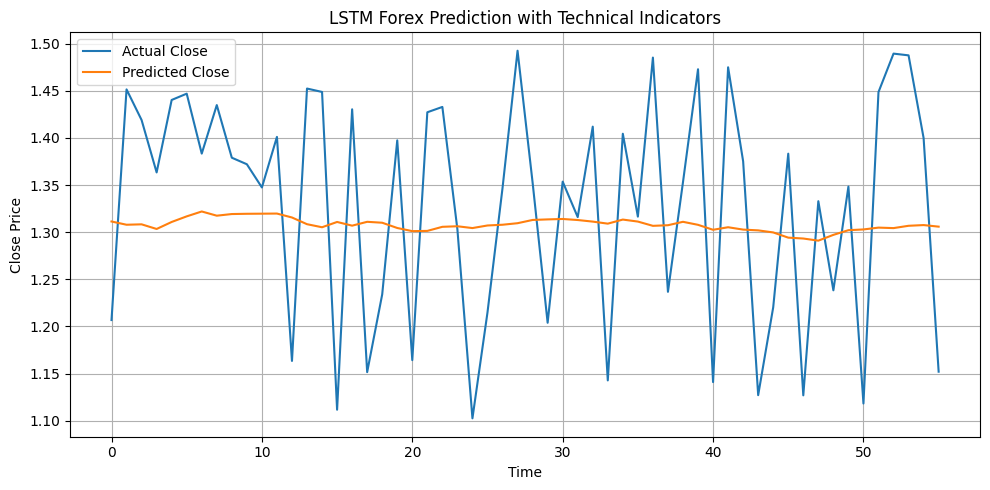

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("C:/Users/SOMEN/Downloads/forex_data.csv")
#df.head()

np.random.seed(42)
n = 300
df = pd.DataFrame({
    'Open': np.random.uniform(1.1, 1.5, n),
    'High': np.random.uniform(1.2, 1.6, n),
    'Low': np.random.uniform(1.0, 1.4, n),
    'Close': np.random.uniform(1.1, 1.5, n)
})

# SMA and EMA
df['SMA'] = df['Close'].rolling(window=10).mean()
df['EMA'] = df['Close'].ewm(span=10, adjust=False).mean()
# RSI
delta = df['Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=14).mean()
loss = (delta.where(delta<0, 0)).rolling(window=14).mean()
rs = gain/loss
df['RSI'] = 100 - (100 / (1+rs))

df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'SMA', 'EMA', 'RSI']
target = ['Close']
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(df[features])
y_scaled = scaler.fit_transform(df[target])

SEQ_LEN = 10
X_seq, y_seq = [], []
for i in range(SEQ_LEN, len(X_scaled)):
    X_seq.append(X_scaled[i-SEQ_LEN:i])
    y_seq.append(y_scaled[i])

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)


# LSTM Model
class ForexLSTM(nn.Module):
    def __init__(self):
        super(ForexLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=X_train.shape[2], hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50,1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])


model = ForexLSTM()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

model.eval()
with torch.no_grad():
    pred = model(X_test_t).numpy()

merged_pred = np.concatenate((X_test[-len(pred):, -1, :-1], pred), axis=1)
merged_actual = np.concatenate((X_test[-len(pred):, -1, :-1], y_test), axis=1)
pred_inv = scaler.inverse_transform(merged_pred)[:, -1]
actual_inv = scaler.inverse_transform(merged_actual)[:, -1]

plt.figure(figsize=(10, 5))
plt.plot(actual_inv, label='Actual Close')
plt.plot(pred_inv, label='Predicted Close')
plt.title("LSTM Forex Prediction with Technical Indicators")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

